# Lab 6: Graphical Models

The goal of this lab session is to code two methods to estimate the structure of undirected gaussian graphical models and compare them.

You have to send the filled notebook named **"L6_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by November 7, 2018 and put **"AML-L6"** in the subject. 

We begin with the standard imports:

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx 
%matplotlib inline
sns.set_context("notebook")
sns.set(style="ticks")
#sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
import warnings
warnings.filterwarnings('ignore')

## Graphical Models

A graphical model is a probabilistic model for which a graph expresses the conditional dependence structure between random variables. The variables are represented by nodes and the relations between them are represented by edges.

### GLasso

Graphical Lasso is the name of the optimization problem that estimates the precision matrix of a multivariate gaussian and its name comes from the direct link with graphical models and the regularization term. 

Fill in the following class that implements the GLasso algorithm optimized by ADMM:

In [12]:
class my_GLasso():
    
    def __init__(self, alpha, mu, max_iter = 60):
        '''
        Parameters:
        alpha : float
            Penalization parameter selected.
        mu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        K_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.covariance_ = None
        self.K_= None
        self.alpha = alpha
        self.mu = mu
        self.max_iter = max_iter
        
    def fit(self, X):
        
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO:
        # initialize K, Z, V 
        n,p = X.shape
        self.covariance_ = np.cov(X.T)
        self.K_= np.linalg.inv(self.covariance_)
        Z = np.eye(p)
        V = np.zeros((p,p))
        converged=False
        n_it=0
        
        #useful functions
        f = lambda u: 1/2*(u + np.sqrt(u**2 + 4/self.mu*np.ones(p)))
        soft_thresholding = lambda u,t: (np.sign(u.flatten())*np.maximum(np.zeros(p*p),np.abs(u.flatten())-t)).reshape(u.shape)
        Norm_1 = lambda M: np.sum(np.triu(M), axis=(0,1))
        Lag = lambda K,Z,V: - np.log(np.abs(np.linalg.det(K))) + np.trace(self.covariance_ @ K) + self.alpha*Norm_1(Z) + self.mu*(np.trace( V.T @(K-Z))) + self.mu/2*np.linalg.norm(K-Z)**2
        
        
        #iterations
        while converged == False and n_it <= self.max_iter:
            n_it += 1
            
            #Precision matrix
            
            Mat = -V + Z - (1/self.mu)*self.covariance_
            D, U  = np.linalg.eig(Mat)
            K_it = U @ np.diag(f(D)) @ U.T
            
            # updating Z
            
            Z_it = soft_thresholding(K_it + V, (self.alpha/self.mu)) 
            
            # updating V
            
            V_it = V + self.mu*(K_it - Z_it)
            if abs(Lag(self.K_,Z,V) - Lag(K_it,Z_it,V_it)) <10e-6:
                converged = True
            
            self.K_ = K_it ; Z = Z_it ; V = V_it

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [29]:
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule, threshold):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        covariance_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.threshold = threshold
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """ 
        n,p = X.shape
        self.graph_structure_ = np.zeros((p,p))
        
        for i in range(p):
            Lasso = LassoCV(max_iter=100000)
            Lasso.fit(np.delete(X,(i), axis=1), X.T[i].T)
            self.graph_structure_[i] = np.insert(Lasso.coef_, i, 0)
        
        if self.rule == "OR":
            
            for i in range(p):
                for j in range(p):
                    if abs(self.graph_structure_[i,j]) > self.threshold or abs(self.graph_structure_[j,i]) > self.threshold:
                        #edge = max(abs(self.graph_structure_[i,j]),abs(self.graph_structure_[j,i]))
                        self.graph_structure_[i,j] = 1
                        self.graph_structure_[j,i] = 1
                    else:
                        self.graph_structure_[i,j] = 0
                        self.graph_structure_[j,i] = 0
            
        elif self.rule == "AND":

            for i in range(p):
                for j in range(p):
                    if abs(self.graph_structure_[i,j]) > self.threshold and abs(self.graph_structure_[j,i]) > self.threshold:
                        #edge = max(abs(self.graph_structure_[i,j]),abs(self.graph_structure_[j,i]))
                        self.graph_structure_[i,j] = 1
                        self.graph_structure_[j,i] = 1
                    else:
                        self.graph_structure_[i,j] = 0
                        self.graph_structure_[j,i] = 0


Generate an easy-to-check (non-trivial, p<=6) example and plot the 4 (real, GLasso, AND, OR) graphs. You can use `networkx` for example to plot.

In [25]:
p=6
from sklearn.datasets import make_spd_matrix
Cov_mat = make_spd_matrix(p)
print(Cov_mat)
data = np.random.multivariate_normal(np.zeros(p),Cov_mat,size=20)

[[ 0.41018403  0.06791494  0.07892517  0.05775373  0.04978182  0.1107928 ]
 [ 0.06791494  0.66847143 -0.0552299   0.00477628 -0.14895747 -0.19804616]
 [ 0.07892517 -0.0552299   4.44426346 -0.28154664  2.70219058 -0.85050034]
 [ 0.05775373  0.00477628 -0.28154664  0.51914064 -0.35375287  0.09554961]
 [ 0.04978182 -0.14895747  2.70219058 -0.35375287  2.59507614 -0.60030881]
 [ 0.1107928  -0.19804616 -0.85050034  0.09554961 -0.60030881  0.90776598]]


#### Fitting our models to the data

In [26]:
Glasso = my_GLasso(1,0.1)
Glasso.fit(data)

In [37]:
MNR_OR = my_nodewise_regression("OR",0.1)
MNR_OR.fit(data)

MNR_AND = my_nodewise_regression("AND",0.1)
MNR_AND.fit(data)

#### Plotting the correlation in graph

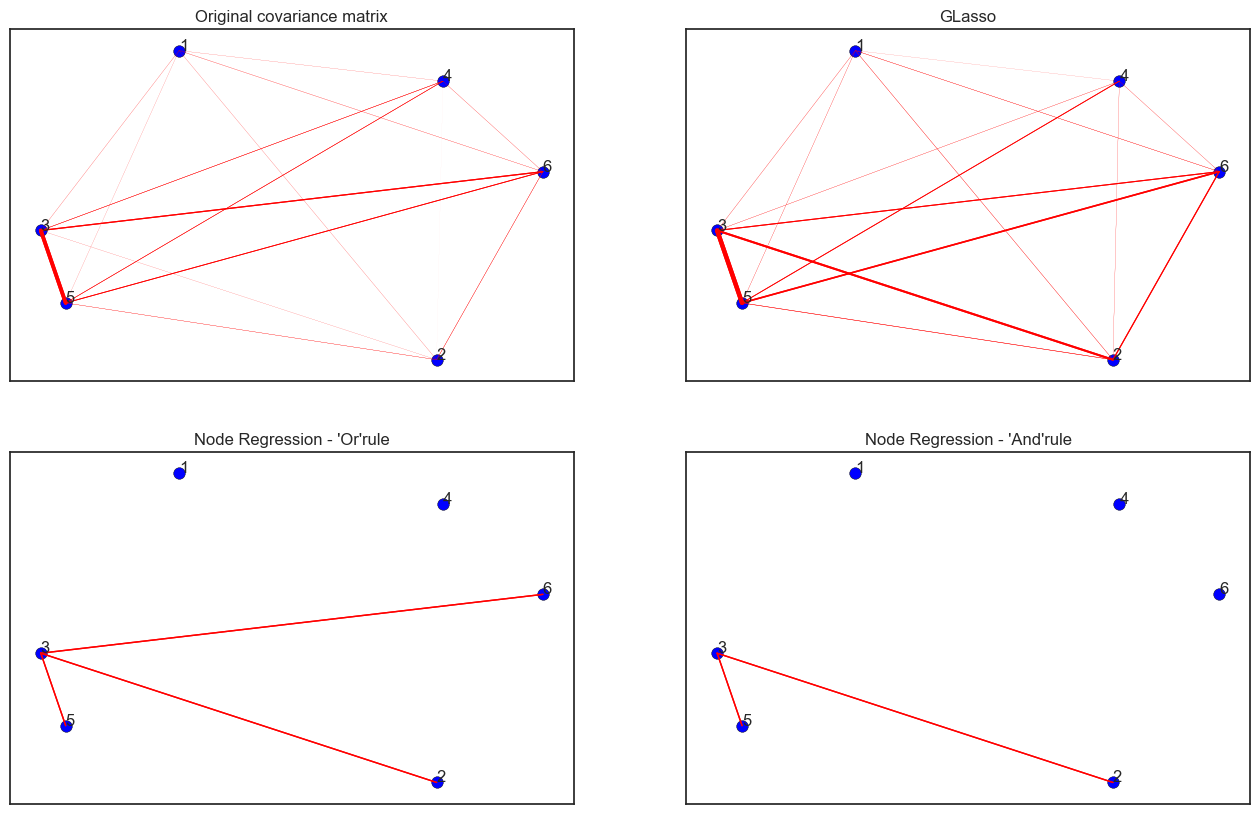

In [35]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))

for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    
# Original data

Graph = networkx.from_numpy_matrix(Cov_mat)
D = networkx.DiGraph(Graph)
pos = networkx.spring_layout(D)
pos_np = np.array(list(pos.values())).T

ax[0,0].scatter(pos_np[0], pos_np[1],s=70)
ax[0,0].set_title("Original covariance matrix")
for i in range(p):
    ax[0,0].annotate(i+1, (pos_np[0,i], pos_np[1,i]))

for i in Graph:
    for j in Graph[i]:
            ax[0,0].plot(pos_np[0, [i, j]], pos_np[1, [i, j]], '-r',alpha=1,linewidth=Cov_mat[i,j])


#GLASSO


ax[0,1].scatter(pos_np[0], pos_np[1],s=70)
ax[0,1].set_title("GLasso")
for i in range(p):
    ax[0,1].annotate(i+1, (pos_np[0,i], pos_np[1,i]))

for i in Graph:
    for j in Graph[i]:
            ax[0,1].plot(pos_np[0, [i, j]], pos_np[1, [i, j]], '-r',alpha=1, linewidth=Glasso.K_[i,j]*10)

_=plt.xticks([])
_=plt.yticks([])

#Node Regression OR 


ax[1,0].scatter(pos_np[0], pos_np[1],s=70)
ax[1,0].set_title("Node Regression - 'Or'rule")
for i in range(p):
    ax[1,0].annotate(i+1, (pos_np[0,i], pos_np[1,i]))

for i in Graph:
    for j in Graph[i]:
            ax[1,0].plot(pos_np[0, [i, j]], pos_np[1, [i, j]], '-r',alpha=1,linewidth = MNR_OR.graph_structure_[i,j])



#NODE REGRESSION AND

#Graph = networkx.from_numpy_matrix(MNR_AND.graph_structure_)
#D = networkx.DiGraph(Graph)
#pos = networkx.spring_layout(D)
#pos_np = np.array(list(pos.values())).T

ax[1,1].scatter(pos_np[0], pos_np[1],s=70)
ax[1,1].set_title("Node Regression - 'And'rule")
for i in range(p):
    ax[1,1].annotate(i+1, (pos_np[0,i], pos_np[1,i]))

for i in Graph:
    for j in Graph[i]:
            ax[1,1].plot(pos_np[0, [i, j]], pos_np[1, [i, j]], '-r',alpha=1,linewidth = MNR_AND.graph_structure_[i,j])

          

**Commentary**: The Networkx library enables us to plot the covariance mat as a graph. On the upper-right, we see that Glasso perform well on the data and seems to weight the correlation relatively closely to the initial covariance mat. Regarding the Nodewise regression, we decided to implement a threshold value under which the correlation are not kept. In this very case, our threshold is a bit high in order to see differences between the "Or" and "AND" rules but we see that the algorithm stil manage to retrieve the most important correlations within the matrix.

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

Report accuracy and F1 score for the edge estimation.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter.


Measure the estimation error of the GLasso matrix result.

#### Creation of the two models 

In [92]:
simulations=[40] #,80,320]
p=300
AR=np.zeros((p,p))
for k in range(0,300,30):
    for i in range(30):
        for j in range(30):
            AR[i+k,j+k] = 0.9**abs(i-j)
            
AR_verif=np.zeros((300,300))
for k in range(0,300,30):
    for i in range(30):
        for j in range(30):
            AR_verif[i+k,j+k] = 1            


Theta=np.ones((p,p))
for i in range(p):
    for j in range(p):
        Theta[i,j]=np.exp(-2*abs(i-j))


Theta_verif = np.zeros((p,p))
for i in range(p):
    for j in range(p):
        
        if Theta[i,j] > 0.099:
            Theta_verif[i,j] = 1 
        else:
            Theta_verif[i,j] = 0
            

## 1 - Node regression performance

### 1 - 1 AR(1)-Block model

In [120]:
for n in simulations: 
    Simu_decay = np.random.multivariate_normal(np.zeros(300),AR,size=n) 
    Glasso_simu = my_GLasso(1,1)
    Glasso_simu.fit(Simu_decay)
    print("GLasso fited")

    MNR_OR_simu = my_nodewise_regression("OR",0.01)
    MNR_OR_simu.fit(Simu_decay)
    
    print("Node reg 'OR' fited")

    MNR_AND_simu = my_nodewise_regression("AND",0.01)
    MNR_AND_simu.fit(Simu_decay)
    
    print("Node reg 'AND' fited")

GLasso fited
Node reg 'OR' fited
Node reg 'AND' fited


In [121]:
from sklearn.metrics import f1_score, accuracy_score

print("f1_score for 'AND' Rule:",
      f1_score(AR_verif.flatten(),MNR_AND_simu.graph_structure_.flatten()),
      "\n",
      "accuracy_score for 'AND' Rule:",
      accuracy_score(AR_verif.flatten(),MNR_AND_simu.graph_structure_.flatten()),
     "\n",)
print("f1_score for 'OR' Rule:",
      f1_score(AR_verif.flatten(),MNR_OR_simu.graph_structure_.flatten()),
      "\n",
      "accuracy_score for 'OR' Rule:",
      accuracy_score(AR_verif.flatten(),MNR_OR_simu.graph_structure_.flatten()))

f1_score for 'AND' Rule: 0.14582484725050915 
 accuracy_score for 'AND' Rule: 0.9068 

f1_score for 'OR' Rule: 0.19459628299234735 
 accuracy_score for 'OR' Rule: 0.8854


**Commentary** The good accuracy score should not hide the poor F1-score of the two node regression model as our matrix is sparse at 90%. The low F1_score might be due to a bad setting of the threshold parameter (set to 0.1). A more comprehensive analysis with the rate of false positive/false negative would help us qualify the F1_score.

### 1 - 2 - Decay Model

In [95]:
for n in simulations: 

    MNR_OR_simu_theta = my_nodewise_regression("OR",0.1)
    MNR_OR_simu_theta.fit(Simu_decay_theta)
    
    print("Node reg 'OR' fited")

    MNR_AND_simu_theta = my_nodewise_regression("AND",0.1)
    MNR_AND_simu_theta.fit(Simu_decay_theta)
    
    print("Node reg 'AND' fited")

GLasso fited
Node reg 'OR' fited
Node reg 'AND' fited


In [96]:
print("f1_score for 'AND' Rule:",
      f1_score(Theta_verif.flatten(),MNR_AND_simu_theta.graph_structure_.flatten()),
      "\n",
      "accuracy_score for 'AND' Rule:",
      accuracy_score(Theta_verif.flatten(),MNR_AND_simu_theta.graph_structure_.flatten()),
     "\n",)
print("f1_score for 'OR' Rule:",
      f1_score(Theta_verif.flatten(),MNR_OR_simu_theta.graph_structure_.flatten()),
      "\n",
      "accuracy_score for 'OR' Rule:",
      accuracy_score(Theta_verif.flatten(),MNR_OR_simu_theta.graph_structure_.flatten()))

f1_score for 'AND' Rule: 0.019569471624266144 
 accuracy_score for 'AND' Rule: 0.9888666666666667 

f1_score for 'OR' Rule: 0.024719101123595506 
 accuracy_score for 'OR' Rule: 0.9807111111111111


**Commentary** Same as above

### GLasso cross-validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

kf = KFold(n_splits=4)
losses=[]
for train_index, test_index in kf.split(Simu_decay):
    print("TRAIN:", train_index, "TEST:", test_index)
    Glasso_simu_AR = my_GLasso(1,1)
    Glasso_simu_AR.fit(Simu_decay[train_index])
    losses.append(log_loss(np.real(Glasso_simu_AR.K_.flatten()).astype('int') ,AR.flatten().astype('int')))
    print(losses[-1])